<a href="https://colab.research.google.com/github/mschrader15/homework/blob/main/spring-2022/ece-693/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

This homework explores forecasting on time series. We will attempt to develop a model that forecasts the closing price of a stock one week in the future. The model ideally should work for any company on the stock market.

## Installing Required Libraries

In [2]:
%pip install pandas
%pip install shap
%pip install sklearn
%pip install plotly
%pip install "nbformat>=4.2.0"
%pip install "pystan==2.19.1.1"
%pip install pandas_market_calendars
%pip install "neuralprophet[live]"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Dataset

The dataset used in this assignment is available from Kaggle: Stock Prediction using Linear Regression - Starter
https://www.kaggle.com/code/nikhilkohli/stock-prediction-using-linear-regression-starter/data

Note that the dataset consists of multiple files:

AAPL.csv
AMZN.csv
FB.csv
GE.csv
GOOGL.csv
GS.csv
IBM.csv
JPM.csv
MSFT.csv
TSLA.csv

** Please keep the dataset files in directory specified by the variable dataset_path **


In [1]:
import os
import pathlib
from typing import Tuple, Union, Any, Iterable, List, Dict
from dataclasses import dataclass
from collections import namedtuple
import glob
from datetime import timedelta
from copy import deepcopy

import pandas_market_calendars as mcal
import pandas as pd
import shap
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from neuralprophet import NeuralProphet
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


ROOT = os.path.abspath("")
dataset_path = pathlib.Path(os.path.join(ROOT, "./data"))
dataset_path


PosixPath('/home/max/tmp/homework/spring-2022/ece-693/HW4/data')

# **Task 1: inspecting the dataset and selecting important features**

The files contain 64 columns and ~3000 rows. Not all columns are meaningful predictors.
Your goal is to keep the features that have predictive power.
There are many ways to select meaningful features, here we will try one of the methods developed specifically for deep learning models.

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model.
The suggested way to select features is to use SHAP with the linear regression model provided at the dataset's Kaggle page.
SHAP is available at https://github.com/slundberg/shap
The page provides several examples of using SHAP, including examples with regression models and Keras.

Method:
Use SHAP library to generate SHAP score for each of the 64 columns (features).
Note that the results may vary from company to company.
Generate SHAP score graphs, set a threshold, keep only the features with the score above the threshold.


### Import the Data

In [2]:
def load_data(dataset_path: pathlib.Path) -> pd.DataFrame:

    nyse = mcal.get_calendar("NYSE")

    tickers: List[str] = []
    data: List[pd.DataFrame] = []
    # Read in the files
    for f in glob.glob(str(dataset_path.joinpath("*.csv")), recursive=False):
        d = pd.read_csv(
            f,
        )
        tickers.append(os.path.split(f)[-1].split(".")[0])
        d["TICKER"] = tickers[-1]
        # d[f"{tickers[-1]}-Close"] = d["Close(t)"]

        # Deal with the schedule. Pull the 1 week close forward
        d = d.set_index(pd.to_datetime(d["Date"]), drop=True)
        shifted = nyse.schedule(
            start_date=pd.to_datetime(d["Date"].min()) + timedelta(days=7),
            end_date=pd.to_datetime(d["Date"].max()),
        )
        tmp = d.loc[shifted.index].reset_index()["Close(t)"]

        # reset the index
        d.reset_index(inplace=True, drop=True)
        d["Close(t+7)"] = tmp
        d.dropna(inplace=True)

        data.append(d)

    # Concatenate into one dataframe
    df = pd.concat(data, ignore_index=True, axis=0)
    df.sort_values("Date", inplace=True)
    df.reset_index(inplace=True, drop=True)

    # fill in the stock data
    # df[[f"{t}-Close" for t in tickers]] = (
    #     df.groupby("Date")[[f"{t}-Close" for t in tickers]]
    #     .transform(lambda x: x.fillna(x.max()))
    #     .fillna(0)
    # )

    return df, tickers


In [3]:
df, tickers = load_data(dataset_path)
df.head()


,Date,Open,High,Low,Close(t),Volume,SD20,Upper_Band,Lower_Band,S_Close(t-1),...,QQQ_MA50,SnP_Close,SnP(t-1)),SnP(t-5),DJIA_Close,DJIA(t-1)),DJIA(t-5),Close_forcast,TICKER,Close(t+7)
0,2000-10-16,22.29,22.57,21.50,21.95,8405600,1.624547,27.691094,21.192906,22.02,...,79.7930,1374.62,1374.17,1402.03,10238.80,10192.18,10568.43,21.05,JPM,21.29
1,2000-10-16,71.04,72.07,69.17,70.80,7710400,3.654238,81.314476,66.697524,69.49,...,79.7930,1374.62,1374.17,1402.03,10238.80,10192.18,10568.43,71.99,IBM,59.17
2,2000-10-16,29.49,29.94,29.29,29.87,13513900,0.675586,31.263173,28.560827,29.49,...,79.7930,1374.62,1374.17,1402.03,10238.80,10192.18,10568.43,28.77,GE,25.74
3,2000-10-17,71.32,72.55,69.17,71.99,8882500,3.430448,80.486396,66.764604,70.80,...,79.5488,1349.97,1374.62,1387.02,10089.71,10238.80,10524.40,60.80,IBM,58.26
4,2000-10-17,29.84,29.84,28.42,28.77,17530200,0.714986,31.309472,28.449528,29.87,...,79.5488,1349.97,1374.62,1387.02,10089.71,10238.80,10524.40,28.71,GE,27.61


### Creating the Linear Regression Model

In [4]:
sampling_rate = 1
sequence_length = 252 // 4  # go back one quarter in trading days
# Delay has already been calculated on data load
batch_size = 64


@dataclass
class DataManager:
    # store the dates
    date_train: pd.Series
    date_val: pd.Series
    date_test: pd.Series

    # x data
    x_train: pd.DataFrame
    x_val: pd.DataFrame
    x_test: pd.DataFrame

    # y data
    y_train: pd.Series
    y_val: pd.Series
    y_test: pd.Series


class StockPredictor(DataManager):
    # Per the Book
    TRAIN_SPLIT = 0.50
    VAL_SPLIT = 0.25

    def __init__(
        self,
        stock: str,
        df: pd.DataFrame,
    ):

        self.stock: str = stock
        self._y_val: pd.Series = None
        self._dates: pd.Series = None

        self._df: pd.DataFrame = self._df_preparer(df)

        # create a list of target features
        self._target_features: List[str] = list(self._df.columns)

        # store the linear regression model
        self._lr: LinearRegression = LinearRegression()

        # store the shap Explainer
        self._explainer: shap.Explainer = None

        # store the facebook prophet
        self._prophet = None

        # flag to track normilization
        self._normalize = False
        self._price_normalized = False

        super().__init__(*self.create_train_test_set())

    def set_data(self, *args) -> None:
        super().__init__(*args)

    def _df_preparer(self, df: pd.DataFrame) -> pd.DataFrame:
        _df = df.loc[df["TICKER"] == self.stock].copy()
        self._dates = _df["Date"].copy()
        _df.set_index("Date", inplace=True, drop=True)
        self._y_val = _df[["Close(t+7)"]].copy()
        _df.drop(
            columns=[
                "Date_col",
                "TICKER",
                "Close_forcast",
                "Close(t+7)",
                # f"{self.stock}-Close",
            ],
            axis=1,
            inplace=True,
        )
        return _df

    @property
    def target_features(
        self,
    ) -> List[str]:
        return self._target_features

    @target_features.setter
    def target_features(self, val: List[str]) -> None:
        self._target_features = val
        # filter the dataframe for only the features that we want
        self._df = self._df[self._target_features].copy()
        # create the test and train dataset again
        self.set_data(*self.create_train_test_set())

    def create_train_test_set(
        self,
    ) -> Tuple[np.ndarray]:
        # This is taken directly from
        # https://www.kaggle.com/code/nikhilkohli/stock-prediction-using-linear-regression-starter/notebook
        data_len = self._df.shape[0]

        # create a chronological split for train and testing
        train_split = int(data_len * StockPredictor.TRAIN_SPLIT)
        val_split = train_split + int(data_len * StockPredictor.VAL_SPLIT)

        # Splitting features and target into train, validation and test samples
        d_train, d_val, d_test = map(
            pd.Series,
            (
                self._dates[:train_split],
                self._dates[train_split:val_split],
                self._dates[val_split:],
            ),
        )

        X_train, X_val, X_test = (
            self._df[:train_split],
            self._df[train_split:val_split],
            self._df[val_split:],
        )
        Y_train, Y_val, Y_test = (
            self._y_val[:train_split],
            self._y_val[train_split:val_split],
            self._y_val[val_split:],
        )

        return d_train, d_val, d_test, X_train, X_val, X_test, Y_train, Y_val, Y_test

    def fit_prophet(
        self,
    ) -> None:
        df = pd.DataFrame(
            {
                "ds": self.date_train.values[: -(sequence_length - 1)],
                "y": self.y_train.values[(sequence_length - 1) :],
                **{
                    col: self.x_train[col].values[: -(sequence_length - 1)]
                    for col in self.target_features
                },
            },
            columns=["ds", "y"] + self.target_features,
        )

        val_df = pd.DataFrame(
            {
                "ds": self.date_val.values[: -(sequence_length - 1)],
                "y": self.y_val.values[(sequence_length - 1) :],
                **{
                    col: self.x_val[col].values[: -(sequence_length - 1)]
                    for col in self.target_features
                },
            },
            columns=["ds", "y"] + self.target_features,
        )

        self._prophet = NeuralProphet(n_lags=sequence_length, n_forecasts=1)
        self._prophet.add_country_holidays(country_name="US")
        # Add in the lagged regressors
        # self._prophet.config_covar
        self._prophet.add_lagged_regressor(self._target_features)
        self._prophet.fit(df, validation_df=val_df)

    def prophet_predict(self, mode: str = "val") -> pd.DataFrame:
        predict_df = pd.DataFrame(
            {
                "ds": getattr(self, f"date_{mode}").values,
                "y": getattr(self, f"y_{mode}").values,
                # **{
                #     col: getattr(self, f"x_{mode}")[col].values
                #     for col in self.target_features
                # },
            },
            columns=["ds", "y"],  # + self.target_features,
        )
        return self._prophet.predict(predict_df)

    def plot_prophet_predict(self, predict_df: pd.DataFrame, mode: str = "val") -> None:
        # from prophet.plot import plot_plotly
        # import plotly.graph_objects as go

        # fig = plot_plotly(self._prophet, predict_df)
        fig = self._prophet.plot(predict_df)
        # fig.add_trace(go.Scatter(x=getattr(self, f"date_{mode}"), y=getattr(self, f"x_{mode}")["Close(t)"]))
        fig.show()

    def fit_sklearn(
        self,
    ) -> None:
        self._lr.fit(self.x_train, self.y_train)
        print(
            f"{self.stock}\tPerformance (R^2): ",
            self._lr.score(self.x_train, self.y_train),
        )

    @property
    def linear_coeffs(
        self,
    ) -> Union[Any, np.ndarray]:
        return self._lr.coef_

    @property
    def linear_intercepts(
        self,
    ) -> Union[Any, np.ndarray]:
        return self._lr.intercept_

    def get_shap_scores(
        self,
    ) -> Any:
        self._explainer = shap.LinearExplainer(
            self._lr,
            self.x_train.values,
        )  # feature_dependence="independent")
        # X_test_array = self.x_test.toarray() # we need to pass a dense version for the plotting functions
        return self._explainer.shap_values(self.x_test.values)

    def plot_shap_scores(self, shap_values: Any) -> None:
        shap.summary_plot(
            shap_values, self.x_test.values, feature_names=self._target_features
        )

    def set_top_features(self, target_features: List[str]) -> None:
        # remove
        self.target_features = target_features

    def plot_features(
        self,
    ) -> None:
        px.line(self._df, x=self._df.index, y=self._target_features).show()

    def normalize_features(
        self,
    ) -> None:
        # Only need to normalize once
        if self._normalize:
            return

        data_len = self._df.shape[0]
        # create a chronological split for train and testing
        train_split = int(data_len * StockPredictor.TRAIN_SPLIT)
        scaler = MinMaxScaler()
        scaler.fit(self._df.iloc[:train_split])
        scaled = scaler.fit_transform(self._df)
        self._df = pd.DataFrame(scaled, columns=self._df.columns, index=self._df.index)
        # Have to re-calculate the data
        self.set_data(*self.create_train_test_set())
        self._normalize = True

    def normalize_price(
        self,
    ) -> None:
        if self._price_normalized:
            return
        
        self._y_scaler = MinMaxScaler()
        scaled = self._y_scaler.fit_transform(self._y_val.values)
        self._y_val = pd.DataFrame(scaled, columns=self._y_val.columns, index=self._y_val.index)
        self.set_data(*self.create_train_test_set())
        self._price_normalized = True

    def unnormalize_price(
        self,
    ) -> pd.Series:
        return self._y_scaler.inverse_transform(self._y_val)

    def mae(self, prediction: pd.Series, mode: str = "val"):
        return metrics.mean_absolute_error(prediction, getattr(self, mode))

    def mape(self, prediction: pd.Series, mode: str = "val") -> float:
        return np.mean(
            np.abs(
                (
                    prediction["y"].values
                    - getattr(self, f"y_{mode}").values
                    / getattr(self, f"y_{mode}").values
                )
            )
        )

    def reduce_features_shap(self, threshold: float) -> List[str]:
        scores = np.abs(self.get_shap_scores()).mean(axis=0)
        top_features = [
            t[1] for t in zip(scores, stock.target_features) if t[0] >= threshold
        ]
        self.target_features = top_features
        return self.target_features


In [5]:


def create_stock_predictors(tickers: List[str], df: pd.DataFrame) -> Iterable[StockPredictor]:

    StockPredictors = namedtuple("StockPredictors", tickers)

    return StockPredictors(
        *(
            StockPredictor(
                ticker,
                df,
            )
            for ticker in tickers
        )
    )


In [ ]:

stock_predictors = create_stock_predictors(tickers, df)


### Fit SKLearn Linear Model

In [7]:
for stock in stock_predictors:
    stock.fit_sklearn()


GS	Performance (R^2):  0.9611869598376043
JPM	Performance (R^2):  0.9548748763072809
GE	Performance (R^2):  0.979277966124468
AMZN	Performance (R^2):  0.9812388283119912
TSLA	Performance (R^2):  0.9616041346687655
FB	Performance (R^2):  0.9839168900927455
MSFT	Performance (R^2):  0.9454697750923909
IBM	Performance (R^2):  0.9662633207928019
AAPL	Performance (R^2):  0.9953933433028688
GOOGL	Performance (R^2):  0.9856011919525404


### Plot the Shap Scores

-------------GS----------------



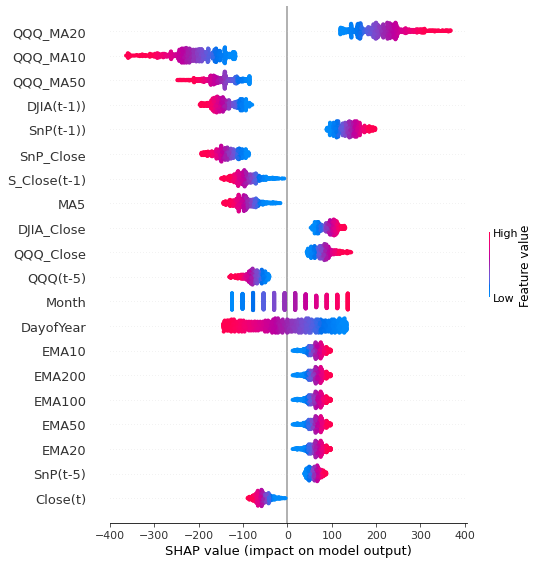

-------------JPM----------------



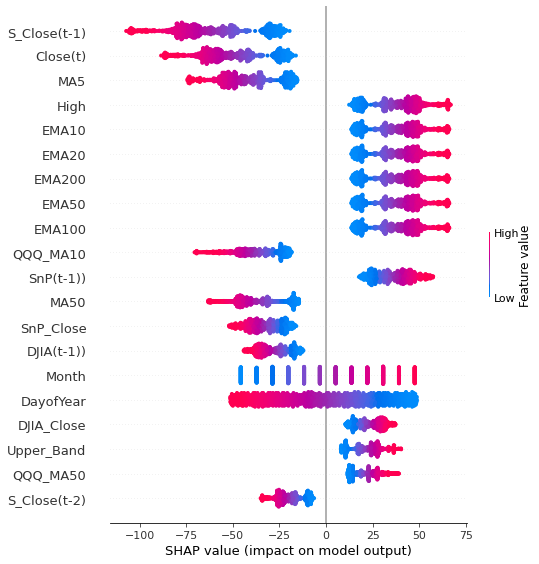

-------------GE----------------



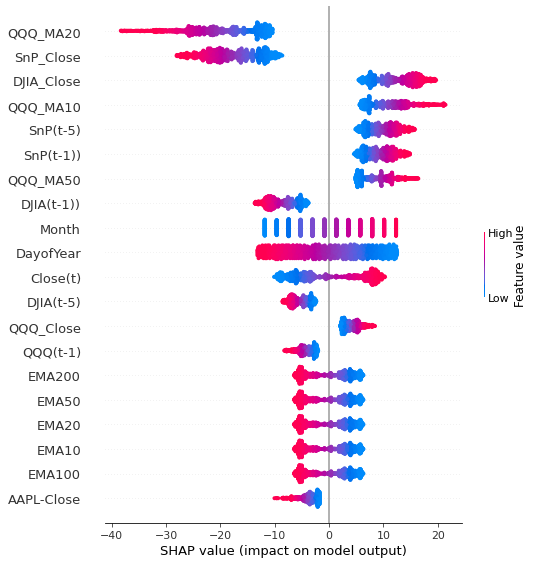

-------------AMZN----------------



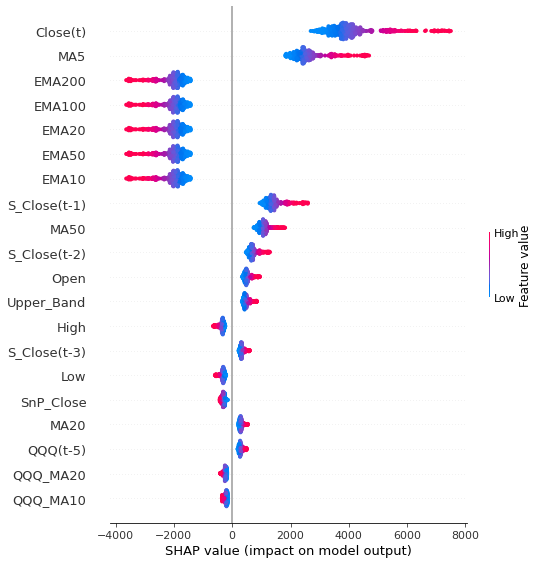

-------------TSLA----------------



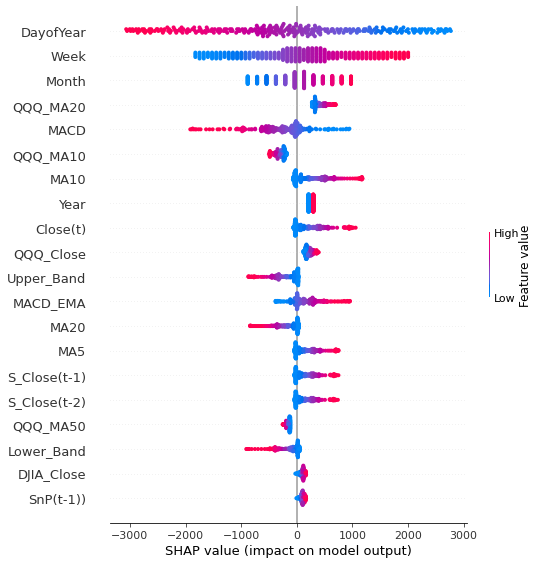

-------------FB----------------



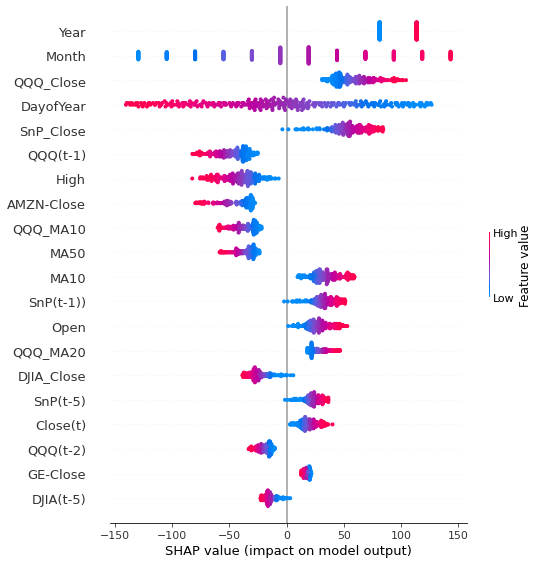

-------------MSFT----------------



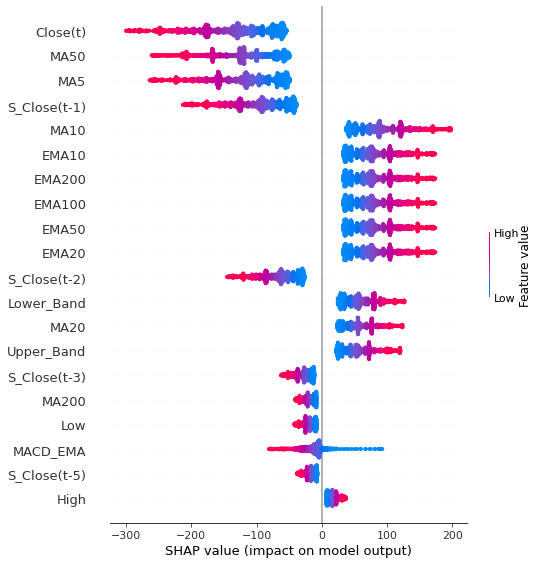

-------------IBM----------------



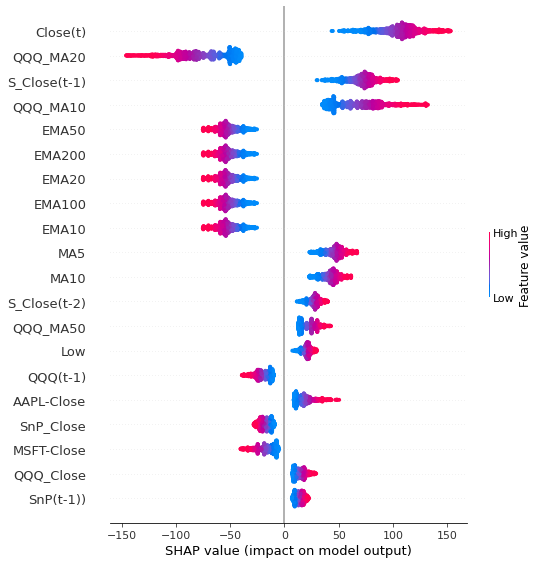

-------------AAPL----------------



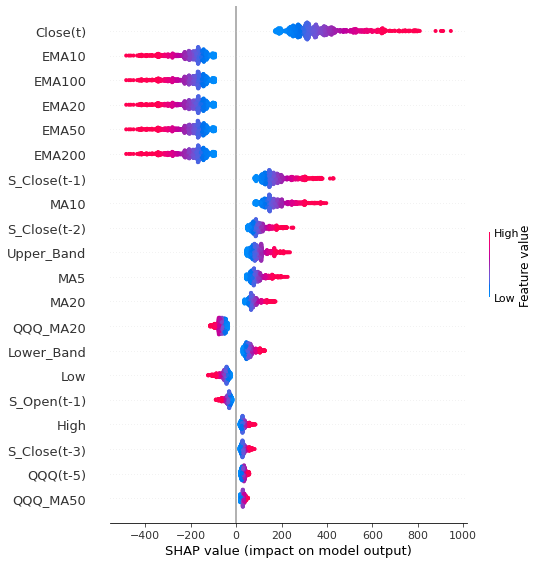

-------------GOOGL----------------



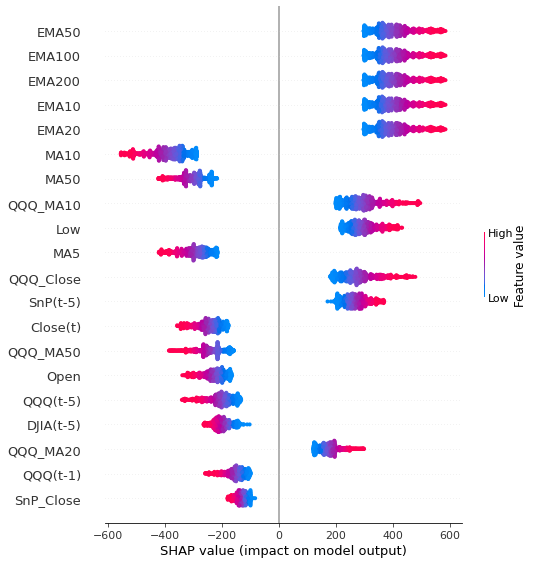

In [7]:
for stock in stock_predictors:
    print(f"-------------{stock.stock}----------------\n")
    stock.plot_shap_scores(stock.get_shap_scores())


### Select only Top Features

In [10]:
SHAP_THRESHOLD = 10  

def filter_features(stock_predictors: Iterable[StockPredictor], num_features: int = SHAP_THRESHOLD) -> None:

    for stock in stock_predictors:
        stock.fit_sklearn()
    

    scores = sum(np.abs(stock.get_shap_scores()).mean(axis=0) for stock in stock_predictors) / len(tickers)

    top_features_tuples = sorted(zip(scores, stock_predictors.AAPL.target_features), reverse=True, key=lambda x: x[0])[:num_features]
    top_features = [t[1] for t in top_features_tuples]

    print(top_features)

    for stock in stock_predictors:
        stock.set_top_features(top_features)


filter_features(stock_predictors)

GS	Performance (R^2):  0.9611869598376043
JPM	Performance (R^2):  0.9548748763072809
GE	Performance (R^2):  0.979277966124468
AMZN	Performance (R^2):  0.9812388283119912
TSLA	Performance (R^2):  0.9616041346687655
FB	Performance (R^2):  0.9839168900927455
MSFT	Performance (R^2):  0.9454697750923909
IBM	Performance (R^2):  0.9662633207928019
AAPL	Performance (R^2):  0.9953933433028688
GOOGL	Performance (R^2):  0.9856011919525404
['Close(t)', 'MA5', 'EMA50', 'EMA100', 'EMA10', 'EMA200', 'EMA20', 'S_Close(t-1)', 'MA50', 'QQQ_MA20']


#### Fitting Prediction with Feature Subset  

In [25]:
for stock in stock_predictors:
    stock.fit_sklearn()


GS	Performance (R^2):  0.9578232345901745
JPM	Performance (R^2):  0.9479237264068835
GE	Performance (R^2):  0.9774221084285474
AMZN	Performance (R^2):  0.9789893966189038
TSLA	Performance (R^2):  0.9454011048184425
FB	Performance (R^2):  0.9777611097897284
MSFT	Performance (R^2):  0.9388490283229995
IBM	Performance (R^2):  0.9640198654577639
AAPL	Performance (R^2):  0.9947529541233472
GOOGL	Performance (R^2):  0.9841427554302105


### Plotting the Timeseries

Using Plotly plots, you can select the variables and it will autosize. They are require lots of memory, so commenting out for now

In [ ]:
for stock in stock_predictors:
    print(f"-------------{stock.stock}----------------\n")
    stock.plot_features()


-------------GS----------------

-------------JPM----------------

-------------GE----------------

-------------AMZN----------------

-------------TSLA----------------

-------------FB----------------

-------------MSFT----------------

-------------IBM----------------

-------------AAPL----------------

-------------GOOGL----------------



In [10]:
for stock in stock_predictors:
    stock.normalize_features()


# **Task 2: a baseline model**
Use any empirical model or a simple machine learning model (e.g. linear regression of the stock price) to predict the price one week in the future from the current date.
Establish a quantitative accuracy measure and evaluate the accuracy of the model.

*Note that the linear regression suggested above is not the same as given in sample code!

### Using Facebook Prophet

https://facebook.github.io/prophet/

In [76]:
# %%capture --no-display

for prophet_stock in stock_predictors:
    prophet_stock.fit_prophet()


INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.391% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.forecaster.__handle_missing_data) - 66 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 66 NaN values in column y were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 66 NaN values in column Open were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 66 NaN values in column Low were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 66 NaN values in column Close(t) were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 66 NaN values in column Upper_Band were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 66 NaN values in column Lower_Band were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 66 NaN values in column S_Close(t-1) were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 66 NaN values in colu

  0%|          | 0/131 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.56E-02, min: 2.89E-04


  0%|          | 0/131 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.30E-03, min: 3.39E-04
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.53E-02
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.295% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.forecaster.__handle_missing_data) - 93 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 93 NaN values in column y were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 93 NaN values in column Open were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 93 NaN values in column High were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 93 NaN values in column Close(t) were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 93 NaN values in column Upper_Band were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 93 NaN values in column Lower_Band were

  0%|          | 0/135 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.77E-04, min: 6.97E-02


  0%|          | 0/135 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.77E-04, min: 2.76E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.22E-03
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.295% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.forecaster.__handle_missing_data) - 93 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 93 NaN values in column y were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 93 NaN values in column Close(t) were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 93 NaN values in column DayofYear were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 93 NaN values in column Month were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 93 NaN values in column QQQ_MA10 were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 93 NaN values in column QQQ_MA20 we

  0%|          | 0/135 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.54E+00, min: 4.70E-07


  0%|          | 0/135 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.09E+00, min: 4.70E-07
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.85E-01
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.246% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.forecaster.__handle_missing_data) - 44 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 44 NaN values in column y were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 44 NaN values in column Open were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 44 NaN values in column High were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 44 NaN values in column Low were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 44 NaN values in column Close(t) were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 44 NaN values in column Upper_Band were auto-i

  0%|          | 0/127 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.68E-03, min: 1.93E-04


  0%|          | 0/127 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.68E-03, min: 1.93E-04
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.96E-03
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.317% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.forecaster.__handle_missing_data) - 19 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 19 NaN values in column y were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 19 NaN values in column Open were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 19 NaN values in column High were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 19 NaN values in column Low were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 19 NaN values in column Close(t) were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 19 NaN values in column Upper_Band were auto-i

  0%|          | 0/119 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.46E-04, min: 2.60E-02


  0%|          | 0/119 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.46E-04, min: 1.54E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.10E-03
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.317% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.forecaster.__handle_missing_data) - 19 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 19 NaN values in column y were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 19 NaN values in column Open were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 19 NaN values in column High were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 19 NaN values in column Low were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 19 NaN values in column Close(t) were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 19 NaN values in column Upper_Band were auto-i

  0%|          | 0/119 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.08E-02, min: 1.10E-03


  0%|          | 0/119 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.61E-03, min: 1.10E-03
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.02E-02
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.391% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.forecaster.__handle_missing_data) - 66 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 66 NaN values in column y were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 66 NaN values in column Open were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 66 NaN values in column High were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 66 NaN values in column Low were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 66 NaN values in column Close(t) were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 66 NaN values in column Upper_Band were auto-i

  0%|          | 0/131 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.43E-01, min: 3.16E-03


  0%|          | 0/131 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.67E-03, min: 2.30E-03
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.20E-02
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.295% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.forecaster.__handle_missing_data) - 93 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 93 NaN values in column y were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 93 NaN values in column Open were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 93 NaN values in column High were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 93 NaN values in column Low were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 93 NaN values in column Close(t) were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 93 NaN values in column Upper_Band were auto-i

  0%|          | 0/135 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.82E-01, min: 3.11E-04


  0%|          | 0/135 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.38E-02, min: 3.22E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.19E-01
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.391% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.forecaster.__handle_missing_data) - 66 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 66 NaN values in column y were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 66 NaN values in column High were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 66 NaN values in column Low were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 66 NaN values in column Close(t) were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 66 NaN values in column Upper_Band were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 66 NaN values in column Lower_Band were 

  0%|          | 0/131 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.83E-04, min: 7.67E-02


  0%|          | 0/131 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.52E+00, min: 4.75E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.77E-02
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.387% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.forecaster.__handle_missing_data) - 56 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 56 NaN values in column y were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 56 NaN values in column Open were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 56 NaN values in column Low were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 56 NaN values in column Close(t) were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 56 NaN values in column Upper_Band were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 56 NaN values in column Lower_Band were 

  0%|          | 0/130 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.08E-04, min: 5.26E-02


  0%|          | 0/130 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.26E-02, min: 3.25E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.17E-02


INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.563% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
WARNING - (py.warnings._showwarnmsg) - The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.567% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.forecaster.__handle_missing_data) - 31 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 31 NaN values in column y were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 31 NaN values in column Open were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 31 NaN values in column Low were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 31 NaN values in column Close(t) were auto-imputed.
INFO - (NP.forecaster._

-------------GS----------------



INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.386% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
WARNING - (py.warnings._showwarnmsg) - The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.388% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.forecaster.__handle_missing_data) - 45 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 45 NaN values in column y were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 45 NaN values in column Open were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 45 NaN values in column High were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 45 NaN values in column Close(t) were auto-imputed.
INFO - (NP.forecaster.

-------------JPM----------------



INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.386% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
WARNING - (py.warnings._showwarnmsg) - The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.388% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.forecaster.__handle_missing_data) - 45 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 45 NaN values in column y were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 45 NaN values in column Close(t) were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 45 NaN values in column DayofYear were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 45 NaN values in column Month were auto-imputed.
INFO - (NP.forec

-------------GE----------------



INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.11% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
WARNING - (py.warnings._showwarnmsg) - The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.117% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.forecaster.__handle_missing_data) - 23 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 23 NaN values in column y were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 23 NaN values in column Open were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 23 NaN values in column High were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 23 NaN values in column Low were auto-imputed.
INFO - (NP.forecaster.__hand

-------------AMZN----------------



INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.026% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
WARNING - (py.warnings._showwarnmsg) - The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.04% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.forecaster.__handle_missing_data) - 11 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 11 NaN values in column y were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 11 NaN values in column Open were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 11 NaN values in column High were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 11 NaN values in column Low were auto-imputed.
INFO - (NP.forecaster.__hand

-------------TSLA----------------



INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.026% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
WARNING - (py.warnings._showwarnmsg) - The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.04% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.forecaster.__handle_missing_data) - 11 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 11 NaN values in column y were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 11 NaN values in column Open were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 11 NaN values in column High were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 11 NaN values in column Low were auto-imputed.
INFO - (NP.forecaster.__hand

-------------FB----------------



INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.563% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
WARNING - (py.warnings._showwarnmsg) - The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.567% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.forecaster.__handle_missing_data) - 31 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 31 NaN values in column y were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 31 NaN values in column Open were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 31 NaN values in column High were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 31 NaN values in column Low were auto-imputed.
INFO - (NP.forecaster.__han

-------------MSFT----------------



INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.386% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
WARNING - (py.warnings._showwarnmsg) - The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.388% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.forecaster.__handle_missing_data) - 45 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 45 NaN values in column y were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 45 NaN values in column Open were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 45 NaN values in column High were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 45 NaN values in column Low were auto-imputed.
INFO - (NP.forecaster.__han

-------------IBM----------------



INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.563% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
WARNING - (py.warnings._showwarnmsg) - The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.567% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.forecaster.__handle_missing_data) - 31 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 31 NaN values in column y were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 31 NaN values in column High were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 31 NaN values in column Low were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 31 NaN values in column Close(t) were auto-imputed.
INFO - (NP.forecaster._

-------------AAPL----------------



INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.402% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
WARNING - (py.warnings._showwarnmsg) - The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.406% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.forecaster.__handle_missing_data) - 28 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 28 NaN values in column y were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 28 NaN values in column Open were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 28 NaN values in column Low were auto-imputed.
INFO - (NP.forecaster.__handle_missing_data) - 28 NaN values in column Close(t) were auto-imputed.
INFO - (NP.forecaster._

-------------GOOGL----------------



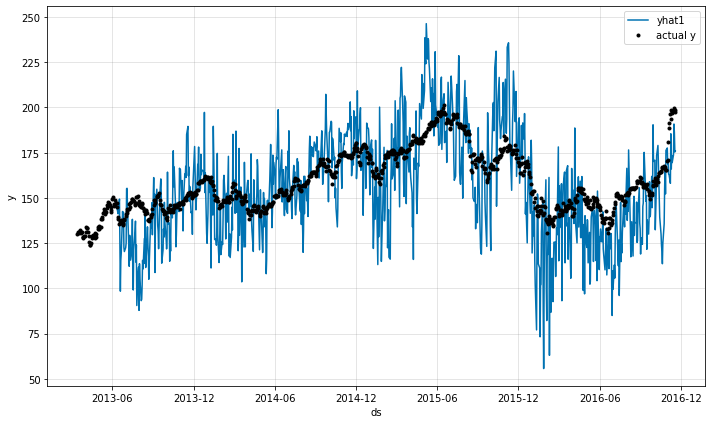

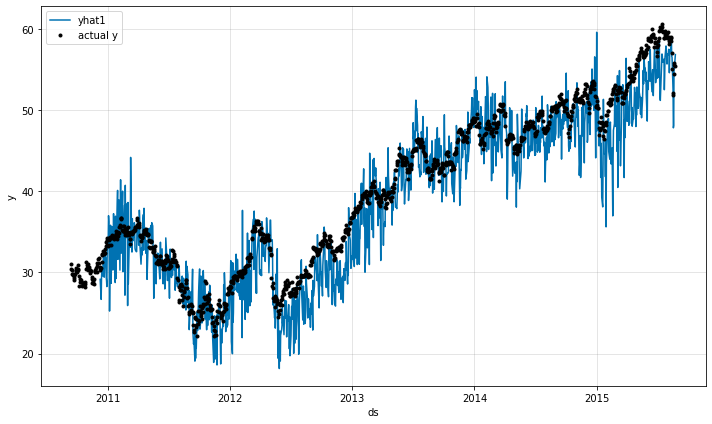

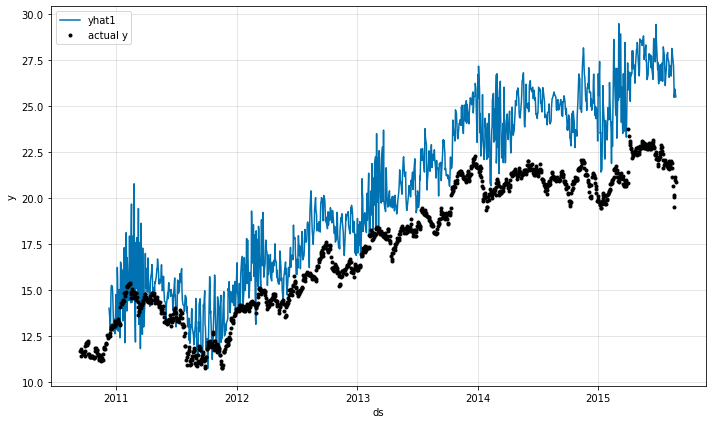

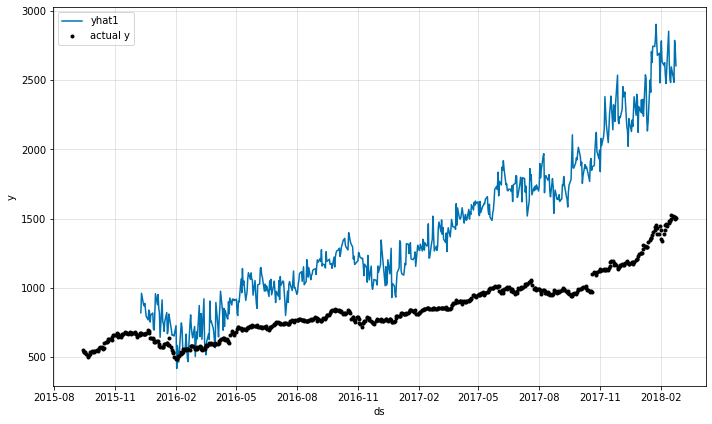

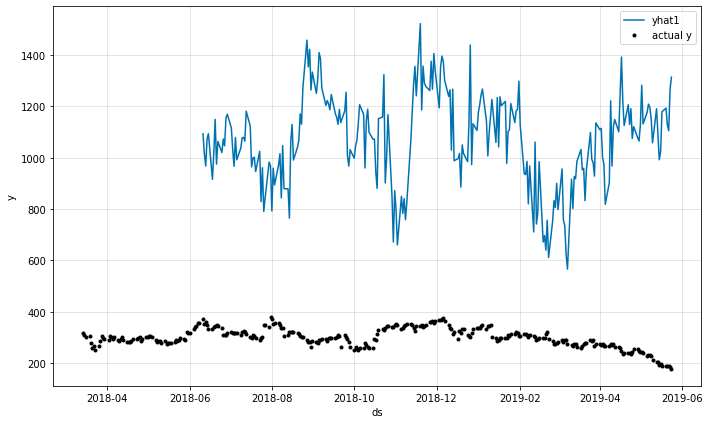

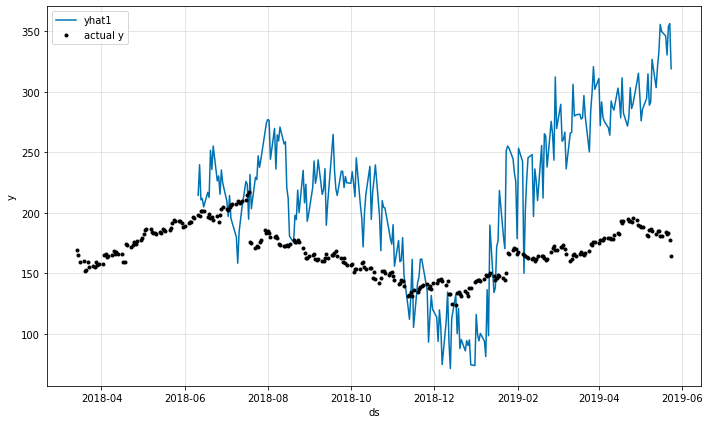

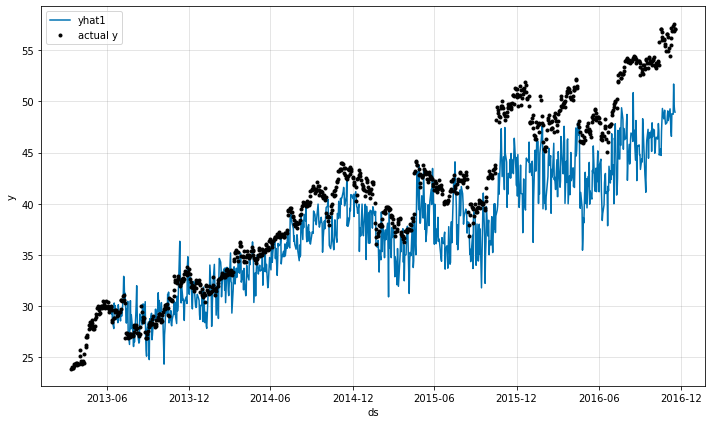

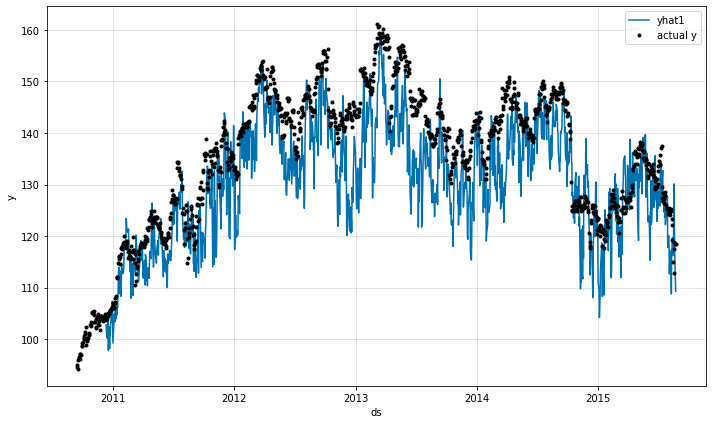

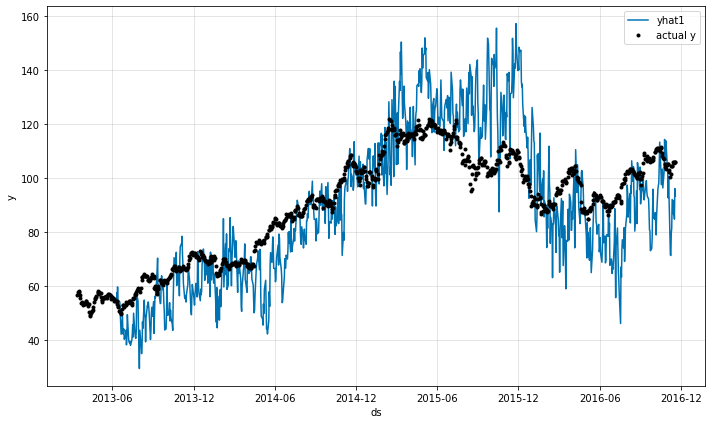

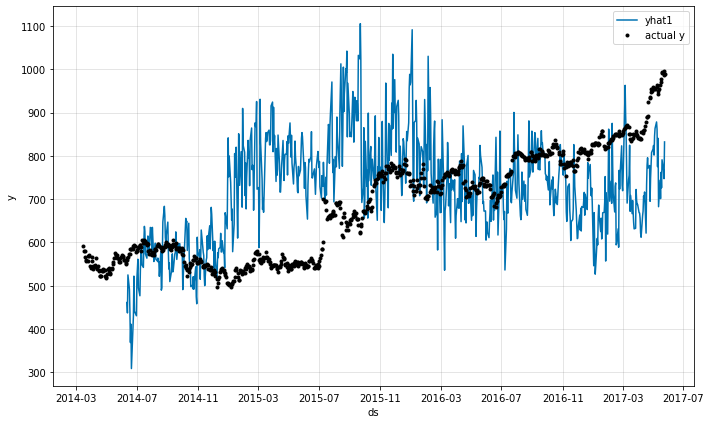

In [80]:
mode = "val"

for prophet_stock in stock_predictors:
    predict_df = pd.DataFrame(
        {
            "ds": getattr(prophet_stock, f"date_{mode}").values,
            "y": getattr(prophet_stock, f"y_{mode}").values,
            **{
                col: getattr(prophet_stock, f"x_{mode}")[col].values
                for col in prophet_stock.target_features
            },
        },
        columns=["ds", "y"] + prophet_stock.target_features,
    )

    prediction = prophet_stock._prophet.predict(predict_df)

    # prediction = prophet_stock.prophet_predict(mode="val")
    print(f"-------------{prophet_stock.stock}----------------\n")
    # print("MAPE = ", prophet_stock.mape(prediction, "val"))
    # prophet_stock.plot_prophet_predict(prediction, "train")
    prophet_stock._prophet.plot(prediction)


# **Task 3: training deep learning models**
Train the following models for forecasting:
1. Based on the Dense layer(s)
2. Based on LSTM layer(s)
3. Based on GRU layers(s)

The selection of model parameters is completely up to you.
You need, however, to investigate and provide in the report:
1. Effect of stacked models
2. Effect of dropout
Quantify the accuracy of each model

**Save the trained models to the same directory as the dataset**

## Dense Layers

In [6]:
class DensePredictor(StockPredictor):
    LEARNING_RATE = 0.0001
    EPOCHS = 50

    def __init__(self, stocks: Iterable[StockPredictor]):
        # The passed df will already be normalized
        # deepcopy here not memory efficient, but want to avoid any mutabilitiy
        # self.__dict__.update(deepcopy(stock.__dict__))
        # try to normalize if the data hasn't already been normalized
        # self.normalize_features()
        self._save_path = "dense.keras"

        self.val_data: tf.data.Dataset = None
        self.test_data: tf.data.Dataset = None
        self.train_data: tf.data.Dataset = None

        # create the tf dataset
        self.create_keras_data(stocks)

        self._keras_model: keras.Model = self.build_model()

        # save the history:
        self.history: Dict = {}

    @staticmethod
    def _create_keras(stock: StockPredictor, mode: str) -> tf.data.Dataset:
        return keras.utils.timeseries_dataset_from_array(
            data=deepcopy(getattr(stock, f"x_{mode}"))
            .values[: -(sequence_length)]
            .astype("float32"),
            targets=deepcopy(getattr(stock, f"y_{mode}"))
            .values[sequence_length :]
            .astype("float32"),
            sampling_rate=1,
            sequence_length=sequence_length,
            batch_size=batch_size,
            shuffle=False,
            
        )

    def create_keras_data(self, stocks: Iterable[StockPredictor]):
        for mode in ["train", "val", "test"]:
            d: tf.data.Dataset = None
            for stock in stocks:
                # stock.normalize_features()
                # stock.normalize_price()
                d = self._create_keras(stock, mode) if d is None else d.concatenate(self._create_keras(stock, mode))

            # shuffle the dataset
            d = d.shuffle(int(d.__len__()))

            # set the keras data
            setattr(self, f"{mode}_data", d)


    @property
    def input_shape(
        self,
    ) -> Tuple[int, int]:
        for inputs, _ in self.train_data.take(1):
            break
        return inputs.shape[1], inputs.shape[2]

    def load_model(
        self,
    ) -> None:
        self._keras_model = keras.models.load_model(self._save_path)

    def build_model(
        self,
    ):
        # get the input size
        inputs = keras.Input(shape=self.input_shape)
        x = keras.layers.Flatten()(inputs)
        x = keras.layers.Dense(264, activation="relu")(x)
        x = keras.layers.Dropout(0.4)(x)
        outputs = keras.layers.Dense(1)(x)
        model = keras.Model(inputs, outputs)
        optimizer = keras.optimizers.RMSprop(DensePredictor.LEARNING_RATE)
        model.compile(
            optimizer=optimizer,
            loss="mse",
            metrics=["mape"],
        )
        return model

    def train_model(
        self,
    ) -> Dict:
        callbacks = [
            keras.callbacks.ModelCheckpoint(self._save_path, save_best_only=True)
        ]

        self.history = self._keras_model.fit(
            self.train_data,
            epochs=self.EPOCHS,
            validation_data=self.val_data,
            callbacks=callbacks,
            # verbose=0,
        )

        return self.history

    def plot_training(
        self,
    ):
        loss = self.history.history["mape"]
        val_loss = self.history.history["val_mape"]
        epochs = range(1, len(loss) + 1)
        plt.figure()
        plt.plot(epochs, loss, "bo", label="Training MAPE")
        plt.plot(epochs, val_loss, "b", label="Validation MAPE")
        plt.title("Training and validation MAPE")
        plt.legend()
        plt.show()

    def plot_predictions(self, mode="test") -> None:
        for x, y in getattr(self, f"{mode}_data").take(2):
            # prediction = self._keras_model.predict(x)
            self._plot_prediction(
                [y.numpy(), y[0].numpy(), self._keras_model.predict(x)[0]],
                1,
                "Single Step Prediction",
            )

    @staticmethod
    def _plot_prediction(plot_data, delta, title) -> None:
        labels = ["History", "True Future", "Model Prediction"]
        marker = [".-", "rx", "go"]
        time_steps = list(range(-(plot_data[0].shape[0]), 0))
        future = delta or 0
        plt.title(title)
        for i, val in enumerate(plot_data):
            if i:
                plt.plot(
                    future, plot_data[i], marker[i], markersize=10, label=labels[i]
                )
            else:
                plt.plot(time_steps, plot_data[i].flatten()[::-1], marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future + 5) * 2])
        plt.xlabel("Time-Step")
        plt.show()
        return


In [24]:

d = DensePredictor(stock_predictors)


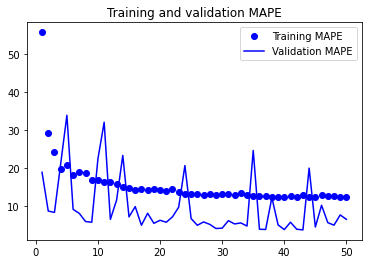

In [21]:
d.train_model()
d.plot_training()

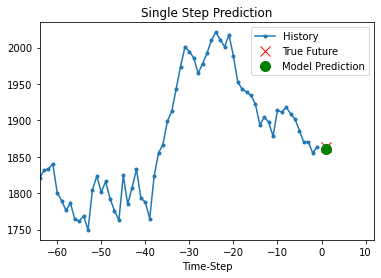

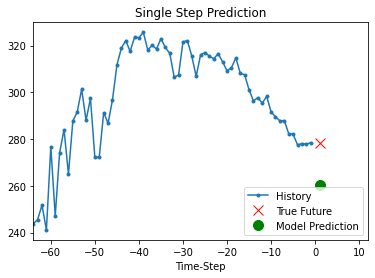

In [25]:
d.load_model()
d.plot_predictions(mode="test")

## LTSM

In [7]:
class LTSMPredictor(DensePredictor):

    LEARNING_RATE = 0.001
    EPOCHS = 10

    def __init__(self, stocks: Iterable[StockPredictor]):
        super().__init__(stocks)

        self._save_path = "ltsm.keras"

    def build_model(
        self,
    ):
        # build the model
        inputs = keras.Input(shape=self.input_shape)
        x = keras.layers.LSTM(264)(inputs)
        x = keras.layers.Dropout(0.4)(x)
        outputs = keras.layers.Dense(1)(x)
        model = keras.Model(inputs, outputs)

        # compile the model
        optimizer = keras.optimizers.RMSprop(self.LEARNING_RATE)
        model.compile(
            optimizer=optimizer,
            loss="mse",
            metrics=["mape"],
        )
        return model


In [58]:

ltsm_predictor = LTSMPredictor(stock_predictors)


### Train the Models

Epoch 1/10
253/253 [==============================] - 34s 126ms/step - loss: 15614.4111 - mape: 47.3661 - val_loss: 85937.3594 - val_mape: 51.1590
Epoch 2/10
253/253 [==============================] - 33s 126ms/step - loss: 12021.2178 - mape: 32.8013 - val_loss: 78487.3594 - val_mape: 40.4409
Epoch 3/10
253/253 [==============================] - 32s 124ms/step - loss: 9722.8311 - mape: 27.7671 - val_loss: 73709.3984 - val_mape: 34.3043
Epoch 4/10
253/253 [==============================] - 33s 125ms/step - loss: 8112.2979 - mape: 24.2489 - val_loss: 69155.1094 - val_mape: 29.6633
Epoch 5/10
253/253 [==============================] - 33s 125ms/step - loss: 6632.6069 - mape: 21.2148 - val_loss: 63399.2305 - val_mape: 23.5817
Epoch 6/10
253/253 [==============================] - 33s 125ms/step - loss: 5369.0273 - mape: 18.8346 - val_loss: 60461.2656 - val_mape: 20.7929
Epoch 7/10
253/253 [==============================] - 33s 125ms/step - loss: 4588.7881 - mape: 17.1220 - val_loss: 58302.9

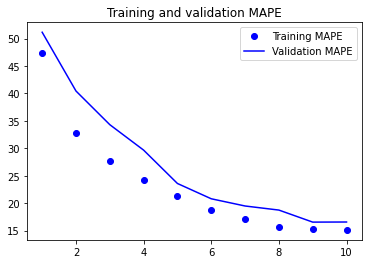

In [59]:
ltsm_predictor.train_model()
ltsm_predictor.plot_training()


### Show Predictions for Models

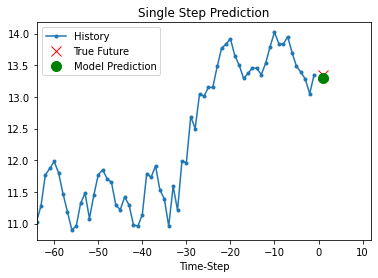

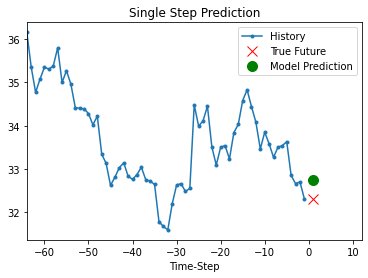

In [60]:
ltsm_predictor.load_model()
ltsm_predictor.plot_predictions(mode="val")


## GRU

In [8]:
class GRUPredictor(DensePredictor):
    
    EPOCHS = 15
    LEARNING_RATE = 0.001

    def __init__(self, stocks: Iterable[StockPredictor]):
        super().__init__(stocks)

        self._save_path = "gru.keras"

    def build_model(
        self,
    ):
        # build the model
        inputs = keras.Input(shape=self.input_shape)
        x = keras.layers.GRU(64, recurrent_dropout=0.5, return_sequences=True)(inputs)
        x = keras.layers.GRU(64, recurrent_dropout=0.5)(x)
        outputs = keras.layers.Dense(1)(x)
        model = keras.Model(inputs, outputs)

        # compile the model
        optimizer = keras.optimizers.RMSprop(self.LEARNING_RATE)
        model.compile(
            optimizer=optimizer,
            loss="mse",
            metrics=["mape"],
        )
        return model


In [74]:

gru_predictor: GRUPredictor = GRUPredictor(stock_predictors)


### Train the Models

Epoch 1/15
253/253 [==============================] - 35s 125ms/step - loss: 17585.7793 - mape: 62.0972 - val_loss: 93390.9141 - val_mape: 66.9414
Epoch 2/15
253/253 [==============================] - 32s 124ms/step - loss: 16122.6582 - mape: 49.4278 - val_loss: 90433.1484 - val_mape: 59.9257
Epoch 3/15
253/253 [==============================] - 32s 123ms/step - loss: 14857.8770 - mape: 41.8363 - val_loss: 87687.9453 - val_mape: 53.2856
Epoch 4/15
253/253 [==============================] - 32s 124ms/step - loss: 13784.6348 - mape: 37.5252 - val_loss: 85128.0938 - val_mape: 52.7770
Epoch 5/15
253/253 [==============================] - 32s 123ms/step - loss: 12757.5605 - mape: 33.5800 - val_loss: 82720.9219 - val_mape: 47.4828
Epoch 6/15
253/253 [==============================] - 32s 124ms/step - loss: 11879.8857 - mape: 30.4181 - val_loss: 80486.2578 - val_mape: 45.6324
Epoch 7/15
253/253 [==============================] - 32s 123ms/step - loss: 11042.0820 - mape: 29.2517 - val_loss: 78

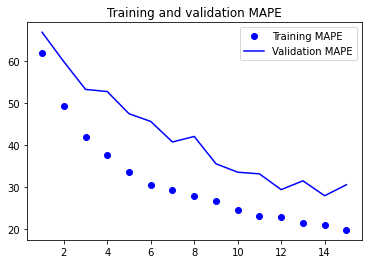

In [75]:

gru_predictor.train_model()
gru_predictor.plot_training()


### Show Predictions for Models

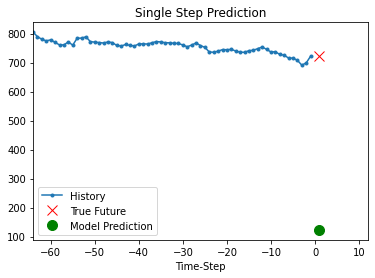

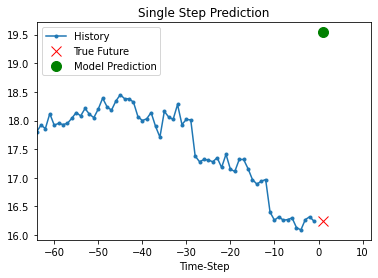

In [76]:
gru_predictor.load_model()
gru_predictor.plot_predictions(mode="val")

# **Task 4: plotting predictions**
Load the trained model from the disk. This is required for me to check the forecast.
Use the variable shown below to specify the company for which we are making the forecast.
Load the data for the company in the range that was not used for training/validation.

Perform inference and plot the forecast values vs actual values.
Print the mean square error of the forecast.

*Note: Since the data needs to be loaded from disk, the code will be much more compact if the loading/feature selection/normalization are made into functions.
*Note: no need to repeat feature selection here. Use previosuly establsihed indices of selected features.

GS	Performance (R^2):  0.9611869598376043
JPM	Performance (R^2):  0.9548748763072809
GE	Performance (R^2):  0.979277966124468
AMZN	Performance (R^2):  0.9812388283119912
TSLA	Performance (R^2):  0.9616041346687655
FB	Performance (R^2):  0.9839168900927455
MSFT	Performance (R^2):  0.9454697750923909
IBM	Performance (R^2):  0.9662633207928019
AAPL	Performance (R^2):  0.9953933433028688
GOOGL	Performance (R^2):  0.9856011919525404
['Close(t)', 'MA5', 'EMA50', 'EMA100', 'EMA10', 'EMA200', 'EMA20', 'S_Close(t-1)', 'MA50', 'QQQ_MA20']


2022-04-11 21:18:09.025750: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-04-11 21:18:09.026672: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-04-11 21:18:09.027032: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


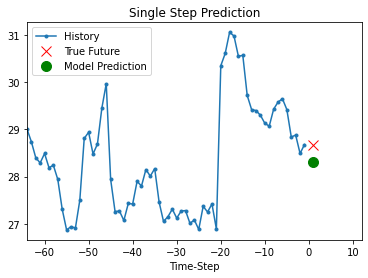

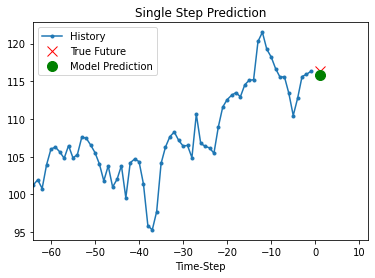

In [11]:
# company to be used in prediction
forecast_for_stock = "GOOGL.csv"
# Mode
mode = "Dense"

# strip .csv if it is there
forecast_for_stock = forecast_for_stock.replace(".csv", "")

# your code here
df, tickers = load_data(dataset_path)

# create the stock predictor, and select the top features
stock_predictors = create_stock_predictors(tickers=tickers, df=df)

# select top features and remove unwanted features
filter_features(stock_predictors)


# Create a class for the desired mode
deep_stock_predictor: DensePredictor = {
    "LTSM": LTSMPredictor,
    "Dense": DensePredictor,
    "GRU": GRUPredictor,
}[mode](stock_predictors)

# load the model
deep_stock_predictor.load_model()

# plot the predictions for validation dataset
deep_stock_predictor.plot_predictions(mode="val")


# **Report**

### Introduction

This assignment (HW 4) asked us to design deep learning predictors for stock-price timeseries, where goal was to predict the stock price 1 week from the current date. 

**It's important to note that I was observing very bad results trying to train ONE predictor on ALL datasets, which made me question the prompt and ultimately convince myself that you were asking for one predictor per stock. In class on Monday, I realized you did mean that the predictor should work for all stocks, so I tried to quickly correct!**  

### Methods

The assignment asked us to predict the stock price a week from current. One tricky aspect of stock prices is that "one week" is not simply a scalar shift on the stock price, as the normal trading week is 5 days, but there are several holidays that complicate the shift. I was apply to shift the stock prices by exactly one week using the NYSE calendar and pandas datetime indexing. 

Before designing the deep learning models, we were asked in Part 1 to load the data and eliminate features that were not useful in explaining the data. The features were identified as being meaningful or not by using the shap python library on Github. 

I used python classes to program in an OOP manner, with class inheritance keeping the code brief. Each stock ticker instantates a "StockPredictor", which can then be used to predict stock prices using the scikit-learn linear regression, the Facebook Prophet, or our own custom deep learning predictors.

I tried different methods of normalization but ultimately found that training the predictors WITHOUT normalization to be the best method. In the training, validation and test sets I shuffled the per-stock training data so that the training function picked randomized stocks. 


### Results

Once the key features were identified, the deep learning forecasters could be applied to the models. I found that the models took a long time to train and frankly ran out of time to truly investigate the effect of stacked models and dropout, however preliminary testing did show that dropout helped with overfitting.

The accuracy of the models was found using the Mean Absolute Percentage Error (MAPE) as the mean absolute error is actually the monetary amount ($) that the model misses the prediction by and the stocks have different values.

GRU never really converged on a good solution

### Discussion



Using the model to compare the errors, I found that the dense neural network had the best combination of training time and performance. 

Several of the stocks are easier to predict than the others, which I think is likely correlated with the P/E ratio or the connection of the stock to "fundementals". The Facebook prophet also showed the ability to be predict certain stocks better than others.